<a href="https://colab.research.google.com/github/WantingZang/PL0-to-MIPS/blob/master/BIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

导入包

In [18]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

一些参数设置

In [19]:
# 活跃集的大小
sizeOfActiveSet = 0
# 最大循环次数
maxIteration = 100

# 最大尝试次数
maxTryTimes = 5
# seed budget
k = 10

图信息

In [20]:
# 有向网络信息加载
g = nx.Graph
G = nx.DiGraph()
G.add_nodes_from(range(0, 348))
g = nx.read_edgelist('/content/0.edges', nodetype=int, create_using=nx.Graph())
g.add_node(348)
for i in g.nodes():
    g.add_edge(348, i)
    g.add_edge(i, 348)
G.add_edges_from(g.edges())
# 点的总数
sumOfNodes = G.number_of_nodes()

for i in G.nodes():
    G.nodes[i]['nodeID'] = i

In [21]:
print(g.number_of_edges())

2853


一些数组初始化

In [22]:
# theta 这个参数我并不知道指示什么：伪代码的说明里没有交代清楚这到底表示什么
activeCurve = np.zeros([maxIteration], dtype=int)
# active node set
# 长度不变
activeSet: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)
# dead node set
# 长度不变
deadSet: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)
# next active node set
# 长度不变
nextActiveSet: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)
# next dead node set
# 长度不变
nextDeadSet: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)

# 在点集中随机抽中2个点作为种子节点(随机次数为2）
# for i in range(0, initialActiveSeed):
#     t = random.randint(0, G.number_of_nodes() - 1)
#     activeSet[t] = True
#     sizeOfActiveSet += 1

# behavioral term
behavioral = np.zeros([max(G.nodes()) + 1, 5], dtype=float)
for i in range(0, max(G.nodes())):
    for j in range(0, 5):
        behavioral[i][j] = np.random.uniform()
# opinion term
# 虽然这里设为1维，但是随着迭代次数增加，会不断变长（数据结构需要优化这里）
# 在此之前：全部设为1，所以完蛋了。
# 20220319：这个是定的随机值！以后意见极化或非极化都是在这个参数中修改!!!!!
omega = [[np.random.uniform() for col in range(1)] for row in range(G.number_of_nodes() + 1)]

# 不确定这个数据怎么算
# 是和谁的相关系数？？
phi = np.zeros([5], dtype=float)
for i in range(0, 5):
    phi[i] = np.random.uniform(0.4, 0.6)


计算函数定义

In [23]:
def Phi(v):
    a = 0
    for i in range(0, 5):
        a += phi[i] * behavioral[G.nodes[v]['nodeID']][i]
    return (a - min(phi)) / (max(phi) - min(phi))


def Omega(u, v, t):
    x : float = omega[G.nodes[v]['nodeID']][t] * (
            1 - np.fabs(omega[G.nodes[u]['nodeID']][0] - omega[G.nodes[v]['nodeID']][t]))
    return x


# propagation possibility

def pp(u, v, t, count):
    denominator = 0
    for n in G.predecessors(v):
        denominator += Omega(n, v, t)
    return pow((Phi(v) * Omega(u, v, t)) / denominator, count)


# 计算意见的标准差
def std(v, t):
    temp = []
    for u in G.predecessors(v):
        temp.append(omega[G.nodes[u]['nodeID']][t])
    temp.append(omega[G.nodes[v]['nodeID']][t])
    return np.std(temp, ddof=1)


def Y_(v, t):
    a = np.zeros([max(G.nodes()) + 1], dtype=bool)
    # in neighbor
    for u in G.predecessors(v):
        if omega[G.nodes[u]['nodeID']][t] <= omega[G.nodes[v]['nodeID']][t] + std(v, t):
            a[G.nodes[u]['nodeID']] = True
    a[G.nodes[v]['nodeID']] = True
    return a


def Y(v, t):
    a = np.zeros([max(G.nodes()) + 1], dtype=bool)
    # in neighbor
    for u in G.predecessors(G.nodes[v]['nodeID']):
        x = omega[G.nodes[u]['nodeID']][t]
        if omega[G.nodes[v]['nodeID']][t] - std(v, t) <= x <= omega[G.nodes[v]['nodeID']][t] + std(v, t):
            a[G.nodes[u]['nodeID']] = True
    a[G.nodes[v]['nodeID']] = True
    return a


# 计算bool类型数组中有多少个True值
def getTrueSum(a):
    return np.sum(a != 0)


# 判断v是否属于A|next D
def isActiveOrDead(v, a, d):
    if a[G.nodes[v]['nodeID']] or d[G.nodes[v]['nodeID']]:
        return True
    else:
        return False


# c是否在v-s集合中
# s是bool类型的数组，标记该位置的节点是否为种子
# 应该计算出一个数组，标记出来哪些点都在这个V-S的集合中
# ?
def isVminusS(s):
    # 初始化标记数组
    a = np.zeros([G.number_of_nodes() + 1], dtype=bool)
    # 对于G图中的每个点
    for i in range(0, G.number_of_nodes() + 1):
        # 点i如果不在s集中
        if not s[i]:
            a[i] = True
    return a


# 判断v的neighbor u是不是active的，t是时间点
def isNeighborActive(v):
    # 如果u是v的in neighbor
    for i in G.predecessors(v):
        # 如果u是active的
        if activeSet[G.nodes[i]['nodeID']]:
            return True
    return False


# 定义一个函数计算I
# 要调用isActiveOrDead
def I(v, count):
    if isActiveOrDead(v, activeSet, deadSet) and count == 1:
        return True
    else:
        return False


# omega updating
def omegaUpdate(v, t, count):
    # 如果在activeset 或 deadset里
    if isActiveOrDead(v, nextActiveSet, nextDeadSet):
        omega[G.nodes[v]['nodeID']].append(1.0)
    # 惩罚更新
    else:
        if isNeighborActive(v) and I(v, count):
            numerator = 0
            denominator = 0
            for u in range(1, max(G.nodes()) + 1):
                if Y(v, t)[G.nodes[u]['nodeID']]:
                    numerator += Omega(v, u, t)
                    denominator += 1 - np.fabs(omega[G.nodes[u]['nodeID']][t] - omega[G.nodes[v]['nodeID']][t])
                    omega[G.nodes[u]['nodeID']].append(numerator / denominator)
        else:
            # 广义更新
            if isNeighborActive(v) and not I(v, count):
                numerator = 0
                denominator = 0
                for u in range(1, max(G.nodes()) + 1):
                    if Y(v, t)[G.nodes[u]['nodeID']]:
                        numerator += Omega(v, u, t - 1)
                        denominator += 1 - np.fabs(
                            omega[G.nodes[u]['nodeID']][t] - omega[G.nodes[v]['nodeID']][t])
                        omega[G.nodes[u]['nodeID']].append(numerator / denominator)
            else:
                omega[G.nodes[v]['nodeID']].append(omega[G.nodes[v]['nodeID']][t])


种子集生成

In [24]:
# 防止数组下标越界，长度+1
# 影响力矩阵
Influence = np.zeros([maxIteration + 1, G.number_of_nodes() + 1, G.number_of_nodes() + 1], dtype=float)
# 惩罚矩阵
P = np.zeros([G.number_of_nodes() + 1, G.number_of_nodes() + 1], dtype=float)

for v in G.nodes():
    # 影响力矩阵初始化
    Influence[0][G.nodes[v]['nodeID']][G.nodes[v]['nodeID']] = 1.0 - omega[G.nodes[v]['nodeID']][0]
    # 惩罚矩阵初始化
    for u in G.nodes():
        if Y_(v, 0)[G.nodes[u]['nodeID']]:
            d = (omega[G.nodes[u]['nodeID']][0] - omega[G.nodes[v]['nodeID']][0]) / np.sum(Y_(v, 0) != 0)
            P[G.nodes[u]['nodeID']][G.nodes[v]['nodeID']] += d
            P[G.nodes[v]['nodeID']][G.nodes[v]['nodeID']] += d

# 循环更新影响力矩阵
for i in range(1, maxIteration + 1):
    # 图中的所有点
    for u in G.nodes():
        # u的out neighbor v
        # omegaUpdate在哪里起作用？？20220316
        count = 1
        # omegaUpdate(u, i, count)
        for v in G.successors(G.nodes[u]['nodeID']):
            # 这个尝试次数的设定有待商榷
            # omegaUpdate(v, i, count)
            Influence[i][G.nodes[u]['nodeID']][G.nodes[v]['nodeID']] += pp(u, v, 0, count) * (
                    Influence[i - 1][G.nodes[v]['nodeID']][G.nodes[v]['nodeID']] - pp(v, u, 0, count) *
                    Influence[i - 2][G.nodes[u]['nodeID']][G.nodes[u]['nodeID']])
            # 20220316 这里公式竟然能打错。。我真是服了我自己
            Influence[i][G.nodes[u]['nodeID']][G.nodes[u]['nodeID']] += Influence[i][G.nodes[u]['nodeID']][
                G.nodes[v]['nodeID']]
        Influence[maxIteration][G.nodes[u]['nodeID']][G.nodes[u]['nodeID']] += Influence[i][G.nodes[u]['nodeID']][
            G.nodes[u]['nodeID']]
# 种子集
S = np.zeros([G.number_of_nodes() + 1], dtype=bool)
# 对，这个theta是怎么定的！20220316
# 这块地方至关重要，我怀疑次次都是重复了第一次的情况
theta = maxIteration
for i_seedSearch in range(1, k + 1):
    # v=argmax
    # argmax数组
    argMax = np.zeros([G.number_of_nodes() + 1], dtype=float)
    for c in G.nodes():
        if not S[G.nodes[c]['nodeID']]:
            argMax[G.nodes[c]['nodeID']] = Influence[theta][G.nodes[c]['nodeID']][G.nodes[c]['nodeID']] + \
                                           P[G.nodes[c]['nodeID']][G.nodes[c]['nodeID']]
    # v是这样计算中的最大的节点
    v = np.argmax(argMax)
    # 将节点v加入到S中
    if not S[G.nodes[v]['nodeID']]:
        S[G.nodes[v]['nodeID']] = True
        activeSet[G.nodes[v]['nodeID']] = True
        sizeOfActiveSet += 1
    # v的in neighbor u
    for u in G.predecessors(G.nodes[v]['nodeID']):
        Influence[maxIteration][G.nodes[u]['nodeID']][G.nodes[u]['nodeID']] -= \
            Influence[maxIteration - 1][G.nodes[u]['nodeID']][
                G.nodes[v]['nodeID']]
        P[G.nodes[u]['nodeID']][G.nodes[u]['nodeID']] -= P[G.nodes[u]['nodeID']][G.nodes[v]['nodeID']] + \
                                                         P[G.nodes[v]['nodeID']][G.nodes[u]['nodeID']]
    omega[G.nodes[v]['nodeID']][0] = 1.0
    # 已访问过的节点
    # bool类型数组
    visited = np.zeros([G.number_of_nodes() + 1], dtype=bool)
    # v的out neighbor
    # b是节点类
    for b in G.successors(G.nodes[v]['nodeID']):
        # a是单个数据
        for a in range(0, len(Y_(G.nodes[b]['nodeID'], 0))):
            if Y_(G.nodes[b]['nodeID'], 0)[a]:
                if not visited[a]:
                    P[a][a] = 0.0
                    P[a][G.nodes[b]['nodeID']] = 0.0
                    # a节点被访问了
                    visited[a] = True
            d = (omega[a][0] - omega[G.nodes[b]['nodeID']][0]) / np.sum(Y_(b, 0) != 0)
            P[a][G.nodes[b]['nodeID']] += d
            P[G.nodes[b]['nodeID']][G.nodes[b]['nodeID']] += d
    print(S)
# 输出最终的S
print(S)
print(sum(S != 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

BIC扩散过程

In [25]:
# active node set
# 长度不变
activeSet_d: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)
# dead node set
# 长度不变
deadSet_d: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)
# next active node set
# 长度不变
nextActiveSet_d: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)
# next dead node set
# 长度不变
nextDeadSet_d: [bool] = np.zeros([max(G.nodes()) + 1], dtype=bool)

activeSet_d=copy.deepcopy(activeSet)
omega_d=copy.deepcopy(omega)

测试深拷贝

In [26]:
print(S)
print(activeSet)
print(activeSet_d)

[False False False False False False  True False  True False False False
 False False False False False False False False False False False False
  True False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [27]:
print(np.where(activeSet==True))

(array([  6,   8,  24,  33,  90, 174, 175, 233, 236, 255]),)


观察omega
一切操作都在omega_d上进行，omega不能动！如果要有新的尝试，一定new新变量

In [28]:
print(omega_d)
print(omega)

[[0.8807656679212644], [0.11955617166934629], [0.9776967651704528], [0.5539594488948669], [0.8675161636791481], [0.06890773961249441], [1.0], [0.13497931801398566], [1.0], [0.9667614017620113], [0.6569088176475294], [0.9885649793538688], [0.04869471109896961], [0.767884427487159], [0.021285153522555778], [0.6635019166252096], [0.11796753297439788], [0.026798647981563062], [0.00043173756643410943], [0.29280314429674104], [0.5311688941384481], [0.11082235792431161], [0.9645900940051579], [0.9062792954619503], [1.0], [0.00015055594244639536], [0.16288470970983582], [0.513799219413983], [0.7943743492441407], [0.8336622381618299], [0.8128517414650015], [0.29994869260226265], [0.6439482185549085], [1.0], [0.6086578890011718], [0.5771146055762376], [0.8629526033608249], [0.40864806083953054], [0.18656680281414906], [0.034766687084893166], [0.2928475314193145], [0.8318263403906001], [0.33947206740105595], [0.24847802650244466], [0.3818233579560353], [0.8048533343478819], [0.6381766949925509], 

In [29]:
print(len(np.array(omega_d)))

350


现在omega_d是对的，保存omega_d

In [30]:
# 被激活的节点的omega被设定为1.0
for v in G.nodes():
    if S[G.nodes[v]['nodeID']]:
        omega_d[G.nodes[v]['nodeID']] = [1.0]
print(omega_d)

[[0.8807656679212644], [0.11955617166934629], [0.9776967651704528], [0.5539594488948669], [0.8675161636791481], [0.06890773961249441], [1.0], [0.13497931801398566], [1.0], [0.9667614017620113], [0.6569088176475294], [0.9885649793538688], [0.04869471109896961], [0.767884427487159], [0.021285153522555778], [0.6635019166252096], [0.11796753297439788], [0.026798647981563062], [0.00043173756643410943], [0.29280314429674104], [0.5311688941384481], [0.11082235792431161], [0.9645900940051579], [0.9062792954619503], [1.0], [0.00015055594244639536], [0.16288470970983582], [0.513799219413983], [0.7943743492441407], [0.8336622381618299], [0.8128517414650015], [0.29994869260226265], [0.6439482185549085], [1.0], [0.6086578890011718], [0.5771146055762376], [0.8629526033608249], [0.40864806083953054], [0.18656680281414906], [0.034766687084893166], [0.2928475314193145], [0.8318263403906001], [0.33947206740105595], [0.24847802650244466], [0.3818233579560353], [0.8048533343478819], [0.6381766949925509], 

现在对omega进行修改，看看omega怎么样

In [31]:
# 被激活的节点的omega被设定为1.0
for v in G.nodes():
    if S[G.nodes[v]['nodeID']]:
        omega[G.nodes[v]['nodeID']] = [1.0]
print(omega)

[[0.8807656679212644], [0.11955617166934629], [0.9776967651704528], [0.5539594488948669], [0.8675161636791481], [0.06890773961249441], [1.0], [0.13497931801398566], [1.0], [0.9667614017620113], [0.6569088176475294], [0.9885649793538688], [0.04869471109896961], [0.767884427487159], [0.021285153522555778], [0.6635019166252096], [0.11796753297439788], [0.026798647981563062], [0.00043173756643410943], [0.29280314429674104], [0.5311688941384481], [0.11082235792431161], [0.9645900940051579], [0.9062792954619503], [1.0], [0.00015055594244639536], [0.16288470970983582], [0.513799219413983], [0.7943743492441407], [0.8336622381618299], [0.8128517414650015], [0.29994869260226265], [0.6439482185549085], [1.0], [0.6086578890011718], [0.5771146055762376], [0.8629526033608249], [0.40864806083953054], [0.18656680281414906], [0.034766687084893166], [0.2928475314193145], [0.8318263403906001], [0.33947206740105595], [0.24847802650244466], [0.3818233579560353], [0.8048533343478819], [0.6381766949925509], 

In [32]:
print(omega)
print(omega_d)

[[0.8807656679212644], [0.11955617166934629], [0.9776967651704528], [0.5539594488948669], [0.8675161636791481], [0.06890773961249441], [1.0], [0.13497931801398566], [1.0], [0.9667614017620113], [0.6569088176475294], [0.9885649793538688], [0.04869471109896961], [0.767884427487159], [0.021285153522555778], [0.6635019166252096], [0.11796753297439788], [0.026798647981563062], [0.00043173756643410943], [0.29280314429674104], [0.5311688941384481], [0.11082235792431161], [0.9645900940051579], [0.9062792954619503], [1.0], [0.00015055594244639536], [0.16288470970983582], [0.513799219413983], [0.7943743492441407], [0.8336622381618299], [0.8128517414650015], [0.29994869260226265], [0.6439482185549085], [1.0], [0.6086578890011718], [0.5771146055762376], [0.8629526033608249], [0.40864806083953054], [0.18656680281414906], [0.034766687084893166], [0.2928475314193145], [0.8318263403906001], [0.33947206740105595], [0.24847802650244466], [0.3818233579560353], [0.8048533343478819], [0.6381766949925509], 

In [33]:
omega=copy.deepcopy(omega_d)
print(omega)

[[0.8807656679212644], [0.11955617166934629], [0.9776967651704528], [0.5539594488948669], [0.8675161636791481], [0.06890773961249441], [1.0], [0.13497931801398566], [1.0], [0.9667614017620113], [0.6569088176475294], [0.9885649793538688], [0.04869471109896961], [0.767884427487159], [0.021285153522555778], [0.6635019166252096], [0.11796753297439788], [0.026798647981563062], [0.00043173756643410943], [0.29280314429674104], [0.5311688941384481], [0.11082235792431161], [0.9645900940051579], [0.9062792954619503], [1.0], [0.00015055594244639536], [0.16288470970983582], [0.513799219413983], [0.7943743492441407], [0.8336622381618299], [0.8128517414650015], [0.29994869260226265], [0.6439482185549085], [1.0], [0.6086578890011718], [0.5771146055762376], [0.8629526033608249], [0.40864806083953054], [0.18656680281414906], [0.034766687084893166], [0.2928475314193145], [0.8318263403906001], [0.33947206740105595], [0.24847802650244466], [0.3818233579560353], [0.8048533343478819], [0.6381766949925509], 

扩散循环

1
active set:
[False  True False  True False  True  True  True  True False  True False
 False  True False False  True False False  True False  True  True  True
  True  True  True False False False  True  True False  True False False
 False False  True  True  True False  True False False  True  True False
  True  True  True False False  True False  True  True  True False  True
 False False  True  True False  True  True  True  True  True False False
  True False False  True False  True False  True  True False  True False
  True  True  True  True  True  True  True  True  True False  True  True
 False False  True  True False  True  True  True  True  True  True False
  True  True  True False  True  True False False False  True  True  True
 False  True  True  True False False False  True False  True  True  True
  True  True  True False  True False False False False  True  True  True
 False  True  True  True  True False False False False  True  True False
 False False  True  True  True  True 

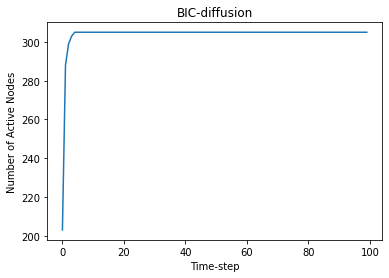

In [34]:
for i_Diffusion in range(0, maxIteration):
    print(i_Diffusion)
    print("active set:")
    print(activeSet_d)
    print("size of active set: ", sizeOfActiveSet)
    # 如果不是所有节点都活跃
    if sizeOfActiveSet < G.number_of_nodes():
        for v in G.nodes():
            # 如果v是活跃节点的话
            if activeSet_d[G.nodes[v]['nodeID']]:
                # 激活机会有5次
                # 对于v节点的后继结点们
                for u in G.successors(v):
                    # 激活阈值为0.5
                    beta = 0.5
                    # 深拷贝活跃集情况
                    nextActiveSet_d = copy.deepcopy(activeSet_d)
                    nextDeadSet_d = copy.deepcopy(deadSet_d)
                    # 如果v节点的后继节点u非活跃
                    if not activeSet_d[G.nodes[u]['nodeID']]:
                        # 尝试激活这么多次
                        for count in range(1, maxTryTimes+1):
                            # 如果u某次被激活了
                            if pp(u, v, i_Diffusion, count) >= beta:
                                # 下一时间段的激活节点标记为true
                                nextActiveSet_d[G.nodes[u]['nodeID']] = True
                                # 再更新active集合
                                activeSet_d[G.nodes[u]['nodeID']] = True
                                # 活跃集节点数增加
                                sizeOfActiveSet += 1
                                # 跳出循环
                                break
                            # 如果用尽了尝试次数，还是没有激活
                            if count == maxTryTimes:
                                # v节点死亡
                                nextDeadSet_d[G.nodes[v]['nodeID']] = True
                                deadSet_d[G.nodes[v]['nodeID']] = True
                            # 更新v节点的omega值
    for each in G.nodes():
        omegaUpdate(each, i_Diffusion, count)
    # 活跃集大小曲线变化
    activeCurve[i_Diffusion] = sizeOfActiveSet
plt.plot(range(0, maxIteration), activeCurve)
plt.xlabel('Time-step')
plt.ylabel('Number of Active Nodes')
plt.title('BIC-diffusion')
plt.show()